<font size=6>**Machine Learning Practices - Model Selection**</font>

# Level 2 $-$ Hyperparameter tuning

> _How do I select the best hyperparameters, and assess the performance?_

<table><tr>
    <td width=800>
        <img src=attachment:Goku_SS1.png>
    </td>
</tr></table>

**Hyperparameter tuning** == **select** the best hyperparameters of a model.

What "**best**" means?  As usual, the ones which return the best metric of performance on some test set.

For example, let's consider the Random Forests **classifier** (RF**C**)

&emsp; $\rightarrow$  <code>sklearn</code> implementation of RFC has 10 tunable hyperparameters (_plus a few more related to the computational execution_):
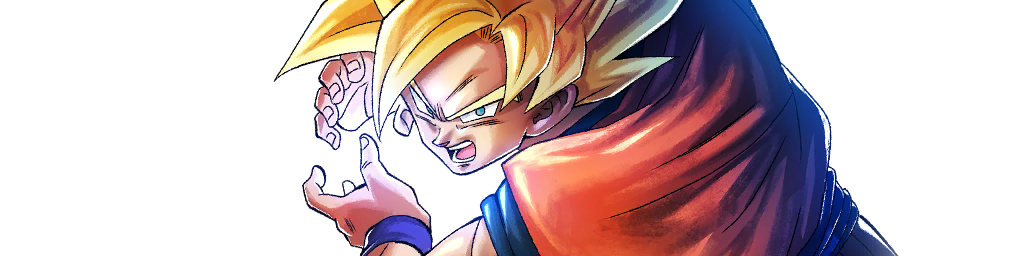

In [1]:
# Let's visualize the RF hyperparameters:
import inspect
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

hyperparams = inspect.signature(clf.__init__)
print(hyperparams)

(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)


## CV for hyperparameter tuning

As anticipated in the previous notebook (`01_ML_Practices.ipynb`) $\rightarrow$ <u>we can use CV</u> to select the best hyperpars.

Let's assume we consider 3 different **hyperparamers sets** (i.e., **configurations**), hence defining 3 estimators:
- _Estimator A_
- _Estimator B_
- _Estimator C_

<table><tr>
    <td width=800>
        <img src=attachment:CV_k4_hyperpar_estimator.png>
        <center>
            <br>
            Figure 1.1.  Cross Validation protocol used as hyperparameter selector.<br>
            Every "<i>Estimator</i>" is setup using a different hyerparameter set.
        </center>
    </td>
</tr></table>

In practice, we proceed in this way:

> 1. We perform the first split into $k$ folds
> 2. We fit all models on the training folds, and record their performance on the validation fold
> 3. We repeat for the next split, until all possible splits are performed

$\rightarrow$ The <u>selected</u> **hyperparameter set** (**configuration**) is the one yielding the **best average performance**.
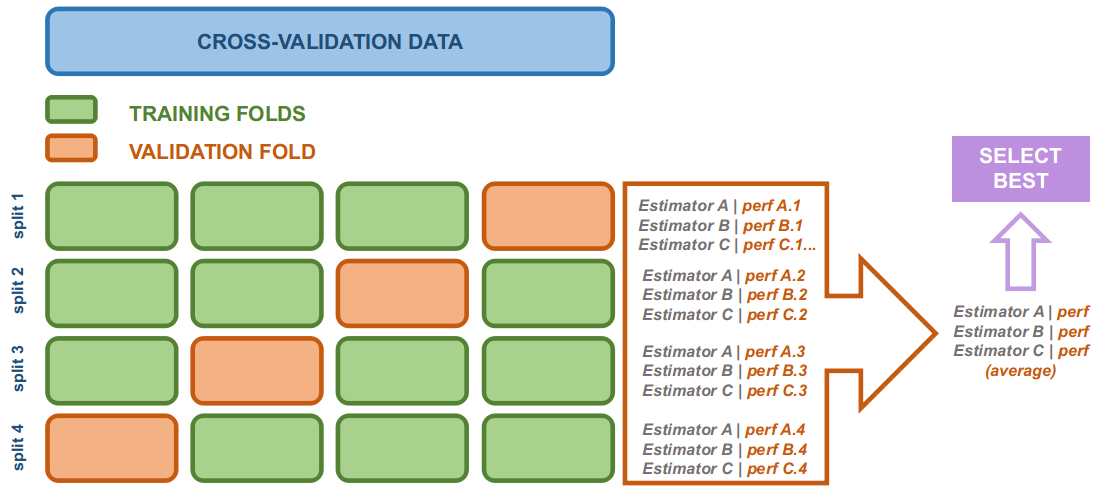

### True performance

> The true performance of the selected model is <u>not</u> the one returned by the CV.

That will be an **overestimate**.

_Why?_ $\rightarrow$ Because we would look at the validation folds both to select the model <u>and</u> to asess it!

> Violation of Golden Rule! $\rightarrow$ <u>The test set must come from the future!</u>

Imagine trying 1 million parameter sets: you will always find a good model which adapts to the data just by chance.
    
_See discussion in [2022 Summer School for Astrostatistics in Crete - ML Practices Workshop](https://github.com/astrostatistics-in-crete/2022_summer_school/blob/main/ML_Practices/ML_Practices_W_answerkey.ipynb) for a mathematical proof._
    
- - -

<u>Solution</u> $\rightarrow$ We need to **hold-out** a test set:

<table><tr>
    <td width=640>
        <img src=attachment:CV_holdout_split.png>
        <center>
            <br>
            Figure 1.2. Hold-out split.
            <br>
        </center>
    </td>
</tr></table>
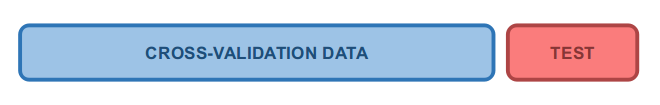

_... If you still don't believe me, believe `sklearn`:_

<table><tr>
    <td width=640>
        <img src=attachment:Hyperpar_Tuning.png>
        <center>
            <br>
            Figure 1.3.  Complete protocol for <b>hyperparameter tuning + testing</b>.<br>
            (From <a href="https://scikit-learn.org/stable/modules/cross_validation.html">this sklearn blog</a>)
        </center>
    </td>
</tr></table>
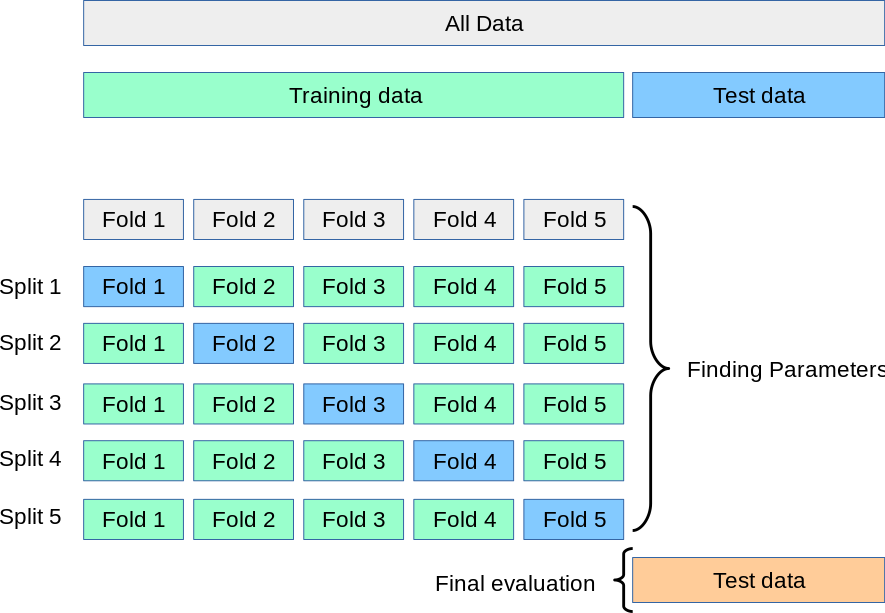

### Example: tuning Random Forests

E.g., consider these <code>sklearn.ensemble</code> Random Forests parameters:
- <code>n_estimators</code> (_the number of trees_)
- <code>max_depth</code> (_the max ramification of the trees_)
- <code>max_features</code> (_the max number of features to consider in each split_)
  
If we want, e.g., to try a 5-fold CV on this **parameter grid**:

In [2]:
param_grid = {
    'n_estimators':  [10, 50],
     'max_depth':    [2, 8],
     'max_features': [3, 5],
}

$\rightarrow$ How many models will we fit?


<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<details>
    
<b><summary>[Spoiler] (click here to expand)</summary></b>
    
That is 2$^3$ = 8 configurations, on a 5-fold CV $\rightarrow$ we will train 8 x 5 + 1 = 41 models.

_NOTE: The final "+1" is because the selected configuration is **retrained on all data**._
    
</details>
</div>

- - -
    
Let's see it action with the usual Kaggle's [Stellar Classification Dataset - SDSS17](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17).<br>

We will perform the full grid search using ``sklearn.model_selection.GridSearchCV``

In [3]:
import pandas as pd
import numpy as np

df_star = pd.read_csv("data/star_classification.csv")
df_star = df_star.sample(n=100, random_state=12)
# keeping only a few objects to make the problem more challenging

features = ['u', 'g', 'r', 'i', 'z']
df_star_ = df_star[features+['class']]
display(df_star_.head(5))

X = df_star_[features].values
y = df_star_['class'].values

print('Number of features in X:', np.shape(X)[1])

,u,g,r,i,z,class
23441,22.30567,21.43649,19.75798,18.96968,18.53585,GALAXY
90125,17.91316,16.73492,16.57163,16.53089,16.53141,STAR
57892,23.00886,22.49020,20.71650,19.74547,19.15290,GALAXY
7228,19.80938,17.89119,16.83623,16.35335,15.95283,GALAXY
99545,24.32647,23.16088,21.35538,20.36712,19.68588,GALAXY


Number of features in X: 5


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Separating hold-out test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(random_state=42)

# Defining the search --------------------------------------------------------
search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', refit=True,
                      n_jobs=1, verbose=3)
'''
Read this as:
    "Perform a Grid Search on estimator <clf> by creating the configurations
    using the parameter grid <param_grid>, and Cross Validation with 5 folds.
    Use accuracy to evaluate the configurations."
    
refit = True
    Will refit the best found model on the whole dataset, which is the actual
    model we shall use for prediction on unseen data!
    
IMPORTANT: A bug in GridSearchCV and RandomizedSearchCV might make them
           extremely slow when `n_jobs` is different from `1`.    
''';
#-----------------------------------------------------------------------------

# Fitting the grid of estimators ---------------------------------------------
search.fit(X_train, y_train)
'''
We pass the whole train dataset --- internally, sklearn does the whole job.
It iterates over the CV loops, and:
    - splits the folds
    - instantiates the estimators with the iteration's hyperparameter set
    - calls the <estimator>.fit() method
    - applies the scoring function
  
IMPORTANT: Notice how we run the CV on the "train" data alone
           (these will be internally split in the CV loops).  
''';
#-----------------------------------------------------------------------------

print('\nBest configuration [selected by <score> = %.2f]:' % search.best_score_)
display(search.best_estimator_)
'''
NOTE: The best configuration is the one with the best _mean_ score across the
      folds, and not the one with the absolute best score!
''';

# Predicting on held-out test:
yhat_test = search.best_estimator_.predict(X_test)
'''
NOTE: The `search.best_estimator_` is just an other `sklearn` estimator (in
      this specific case, a RandomForest object).
      This uses the usual sklearn syntax, but on the search object.
      Hence, it has its own `fit()`, `predict()`, etc. methods, that we can
      invoke as usual.
''';

# Evaluating score:
score = accuracy_score(y_test, yhat_test)

print('\nAccuracy of best configuration on held-out test set: %.2f' % score)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END max_depth=2, max_features=3, n_estimators=10;, score=0.857 total time=   0.0s
[CV 2/5] END max_depth=2, max_features=3, n_estimators=10;, score=0.571 total time=   0.0s
[CV 3/5] END max_depth=2, max_features=3, n_estimators=10;, score=0.643 total time=   0.0s
[CV 4/5] END max_depth=2, max_features=3, n_estimators=10;, score=0.714 total time=   0.0s
[CV 5/5] END max_depth=2, max_features=3, n_estimators=10;, score=0.643 total time=   0.0s
[CV 1/5] END max_depth=2, max_features=3, n_estimators=50;, score=0.786 total time=   0.1s
[CV 2/5] END max_depth=2, max_features=3, n_estimators=50;, score=0.786 total time=   0.1s
[CV 3/5] END max_depth=2, max_features=3, n_estimators=50;, score=0.714 total time=   0.1s
[CV 4/5] END max_depth=2, max_features=3, n_estimators=50;, score=0.786 total time=   0.1s
[CV 5/5] END max_depth=2, max_features=3, n_estimators=50;, score=0.643 total time=   0.1s
[CV 1/5] END max_depth=2, max_

RandomForestClassifier(max_depth=8, max_features=3, n_estimators=10,
                       random_state=42)


Accuracy of best configuration on held-out test set: 0.77


### Hyperparameter search strategy

> _Which strategy shall we choose to explore the hyperparameter space?_   
> _$-$ i.e., which hyperparameter configurations shall we check?_

Let's say we want to explore this parameter space:

In [5]:
param_grid = {
    'n_estimators':      [5, 10, 50, 100],
    'criterion':        ['gini', 'entropy'],
    'max_depth':        [2, 3, 4, 5],
    'min_samples_split':[2, 3],
    'min_samples_leaf': [1, 2, 3],
    'max_features':     [3, 5],
}

import itertools
combinations = itertools.product(*(param_grid[param] for param in sorted(param_grid)))
print('This parameter grid will spawn %s models (per CV iteration)' % len(list(combinations)))

This parameter grid will spawn 384 models (per CV iteration)


The hyperparameter space is **potentially infinite** $\rightarrow$ Grid Search may be **too demanding**!

One alternative approach (_and surprisingly effective!_) is:
> **Random Search**: Try randomly drawn parameter configurations until a pre-determined limit


<table><tr>
    <td width=600>
        <img src=attachment:Grid_vs_Random.png>
        <center>
            <br>
            Which search method sounds better to you? Let us know in the comment below!<br>
            And don't forget to smash the subscribe button!
        </center>
    </td>
</tr></table>

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<details>
    
<b><summary>[Spoiler] (click here to expand)</summary></b>
    
<i>Sorry, you should have followed the example in class :)</i>
    
Yet, you can consult this great [blog](https://blogs.sas.com/content/subconsciousmusings/2020/04/08/maximize-model-performance) on the subject.
    
</details>
</div>

- - - 

Enter `sklearn.model_selection.RandomizedSearchCV`
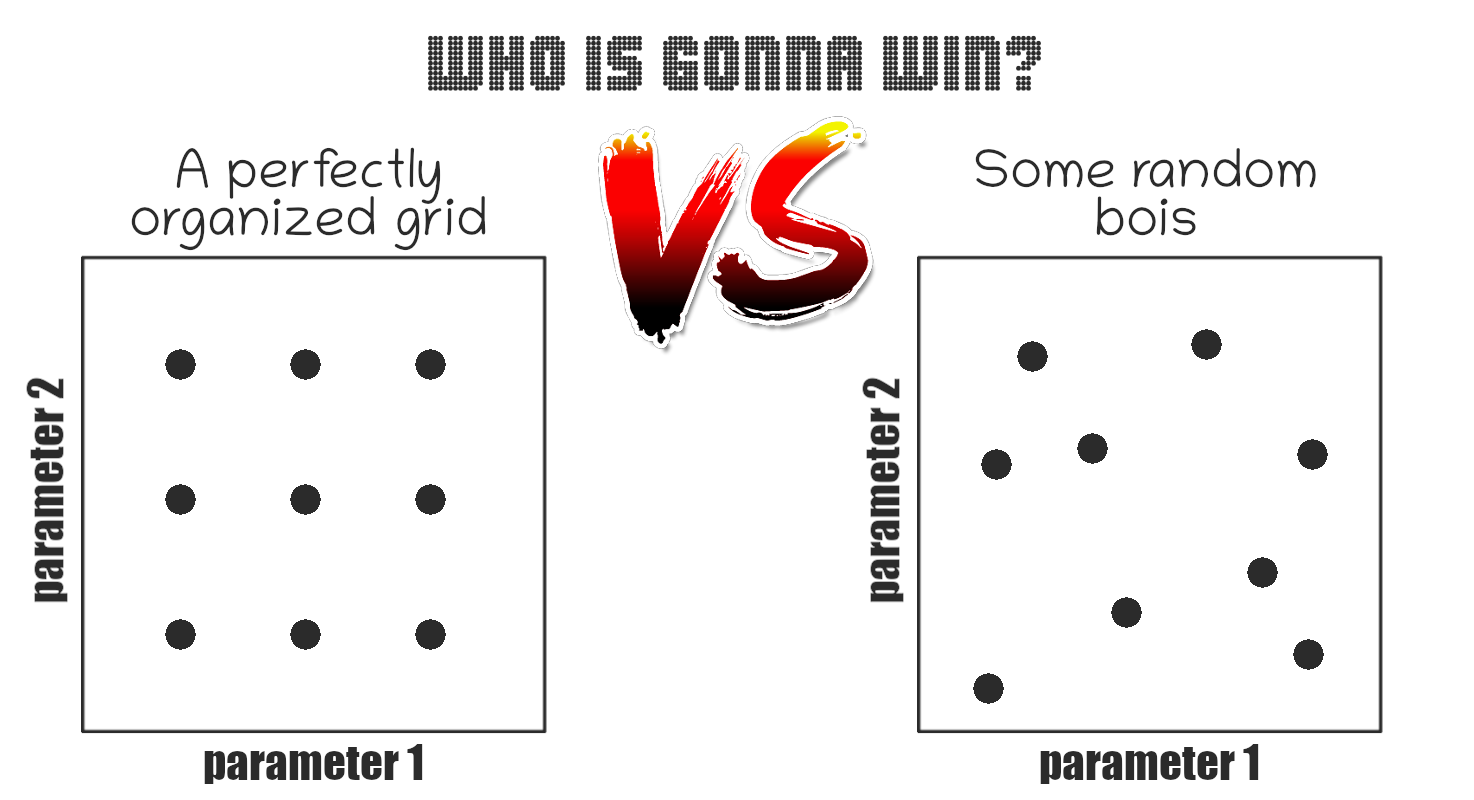

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Separating hold-out test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(random_state=42)

# Defining the search --------------------------------------------------------
search = RandomizedSearchCV(clf, param_grid, cv=5, n_iter=20,
                            scoring='accuracy', refit=True, random_state=42,
                            n_jobs=1, verbose=3)
'''
Read this as:
    "Perform a Random Search on estimator <clf> by creating <n_iter>
    configurations at random, using the parameter grid <param_grid>, and
    Cross Validation with 5 folds.
    Use accuracy to evaluate the configurations.""
    
refit = True
    Will refit the best found model on the whole dataset, which is the actual
    model we shall use for prediction on unseen data!
    By doing that, after the training is complete, we can just predict by 
    using the standard sklearn syntax.

NOTE: The total number of performed fits will be:
          <n_iter> x <cv> (+1)
''';
#-----------------------------------------------------------------------------

# Fitting the grid of estimators ---------------------------------------------
search.fit(X_train, y_train)
#-----------------------------------------------------------------------------

print('\nBest configuration [selected by <score> = %.2f]:' % search.best_score_)
display(search.best_estimator_)

# Predicting on held-out test:
yhat_test = search.best_estimator_.predict(X_test)

# Evaluating score:
score = accuracy_score(y_test, yhat_test)

print('\nAccuracy of best configuration on held-out test set: %.2f' % score)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END criterion=entropy, max_depth=3, max_features=5, min_samples_leaf=1, min_samples_split=3, n_estimators=5;, score=0.786 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=3, max_features=5, min_samples_leaf=1, min_samples_split=3, n_estimators=5;, score=0.571 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=3, max_features=5, min_samples_leaf=1, min_samples_split=3, n_estimators=5;, score=0.714 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=3, max_features=5, min_samples_leaf=1, min_samples_split=3, n_estimators=5;, score=0.786 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=3, max_features=5, min_samples_leaf=1, min_samples_split=3, n_estimators=5;, score=0.643 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=3, max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.786 total time=   0.1s
[CV 2/5] END criterion=entropy, max_d

[CV 4/5] END criterion=gini, max_depth=4, max_features=3, min_samples_leaf=3, min_samples_split=3, n_estimators=50;, score=0.643 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=3, min_samples_leaf=3, min_samples_split=3, n_estimators=50;, score=0.643 total time=   0.1s
[CV 1/5] END criterion=entropy, max_depth=2, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.786 total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=2, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.857 total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=2, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.643 total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=2, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.786 total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=2, max_features=3, min_samples_leaf=1, min_samples_spl

RandomForestClassifier(max_depth=3, max_features=3, min_samples_leaf=2,
                       n_estimators=5, random_state=42)


Accuracy of best configuration on held-out test set: 0.77


# Level 3 $-$ Pipeline tuning

> _What if I have a more complex analysis pipeline?_

<table><tr>
    <td width=800>
        <img src=attachment:Goku_SS2.png>
    </td>
</tr></table>
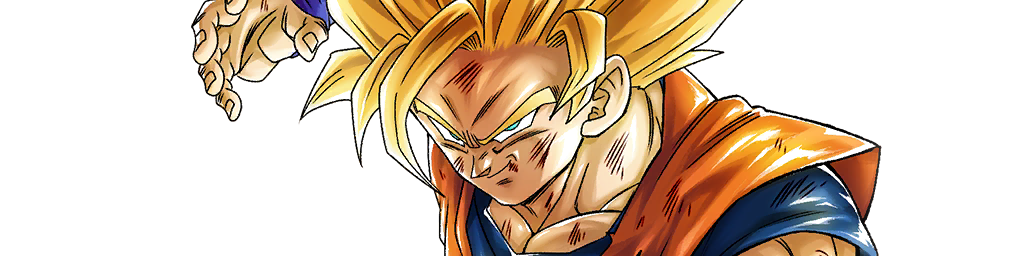

Let's make it more complicated: let's add some preprocessing, which becomes part of the **pipeline**.

So now the model is _not just_ the classifier, but:

> **Model** = **preprocessing + classifier**.

Recall that in general, a model contains _all_ the steps that go from the **input** to the **output** and that must be trained concurrently (**golden rule**):

<table><tr>
    <td width=640>
        <img src=attachment:Model.jpg>
        <center>
            <br>
            Figure 2.1.  A generic model template, containing several other steps apart from the Classifier.
            <br>
        </center>
    </td>
</table></tr>
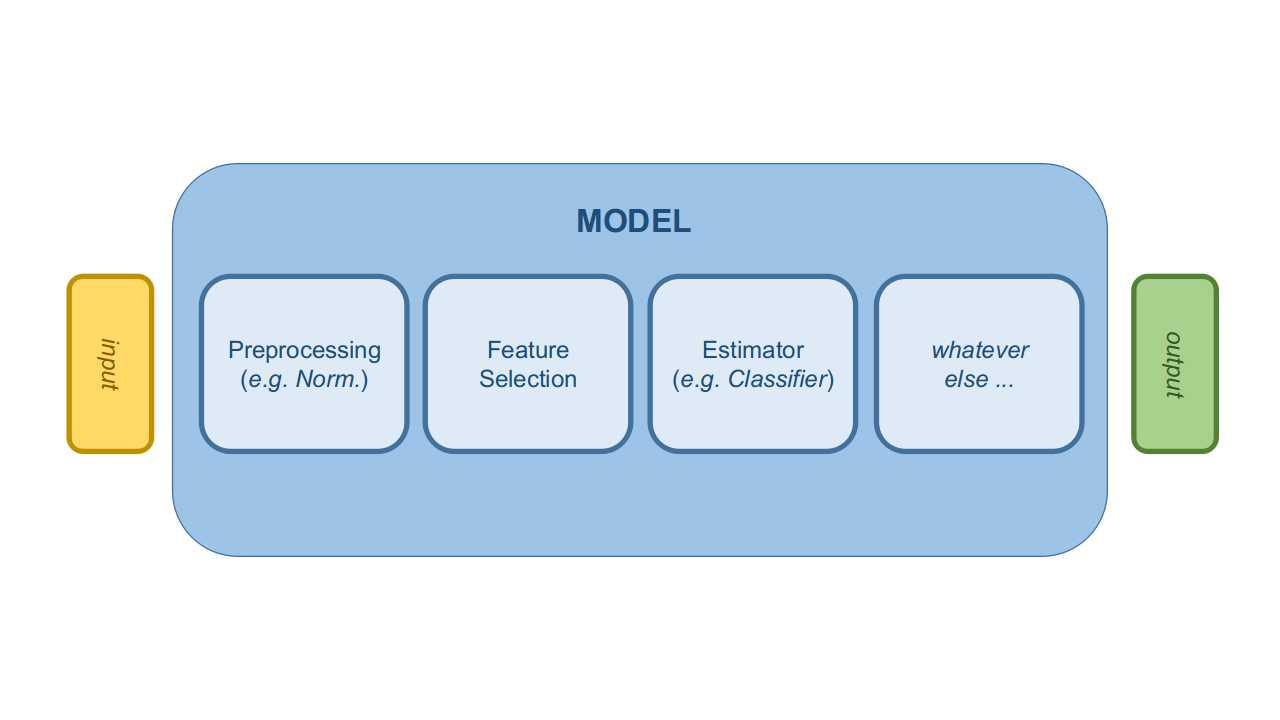

Looks obvious. Right? Let's see:

- - -
<div class="alert alert-block alert-warning" style="margin-top: 20px">

Algorithm **Do_Classification**

**Input**: **$X$** (data matrix), $y$ (labels), classifier<br>
**Output**: classifier accuracy

- - -
> 1. **Normalize data**<br>
> $\mu_X$ $\leftarrow$ $mean~$(**$X$**)<br>
> $X_n$ = $X$ / $\mu_X$
><br>
>
> 2. **Split train/test**<br>
> $indexes\_train~,~indexes\_test \leftarrow split\_indexes(~...~)$<br><br>
> $X_n\_train \leftarrow X_n~[indexes\_train]$<br>
> $X_n\_test ~~\leftarrow X_n~[indexes\_test]$<br>
> $y\_train \leftarrow~y~[indexes\_train]$<br>
> $y\_test ~~\leftarrow~y~[indexes\_test]$<br>
><br>
>
> 3. **Train on $train$ set**<br>
> <code>classifier.fit</code>($X_n\_train, y\_train$)
><br>
>
> 4. **Predict $test$ labels with trained classifier**<br>
> $\hat{y}\_test$ $\leftarrow$ <code>classifier.predict</code>($X_n\_test$)
><br>
>
> 5. **Calculate accuracy**<br>
> $acc \leftarrow calculate\_accuracy~(\hat{y}\_test, y\_test)$<br>
> return $acc$
   
- - -

Where was the mistake?
</div>

    
<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<details>
    
<b><summary>[Spoiler] (click here to expand)</summary></b>
    
Space-time continuum is at risk when you use the test data during the <i>learning</i> process.
    
</details>
</div>

<font size=3><u>**Notation Warning**</u><font>

We can see these names used interchangeably, but their $un$-ambiguous definitions would be:

> - **configuration**: a specific set of hyperparameters (_defines which algorithms we pick and their tuning_)
> - **model**: a fitted configuration (_the same configuration trained on 2 different sets gives birth to 2 different models_)

- Here's how we assemble a **model pipeline** using `sklearn.pipeline.Pipeline`:

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import QuantileTransformer
# NOTE: The QuantileTransformer is just a scaler.
#       Its `n_quantiles` hyperparameters sets the number of bins to split
#       the data in, before re-normalizing.
from sklearn.pipeline import Pipeline

model = Pipeline([('scaler', QuantileTransformer()), ('RFC', RandomForestClassifier())])

display(model)

Pipeline(steps=[('scaler', QuantileTransformer()),
                ('RFC', RandomForestClassifier())])

- And here's how we set its hyperparameter **search ranges**:

In [8]:
import numpy as np

param_grid = {
    "scaler__n_quantiles": [5, 10], 
    "RFC__n_estimators": [10, 20, 50, 100],
    "RFC__max_depth": np.arange(2, 10, 2),
}
'''
The syntax of this dictionary is:
    <label_as_you_defined_in_pipe>__<parameter_name_as_in_sklearn_documentation>
Type, e.g.:
    RandomForestClassifier?
to visualize all the possible parameters

NOTE: If a processing step needs no hyperparamters (e.g. `StandardScaler`),
      you do not need to specify anything in the `param_grid`.
''';

display(param_grid)

{'scaler__n_quantiles': [5, 10],
 'RFC__n_estimators': [10, 20, 50, 100],
 'RFC__max_depth': array([2, 4, 6, 8])}

Finally, you would invoke the search by passing `model` to `RandomizedSearchCV`:

In [9]:
search = RandomizedSearchCV(model, param_grid, cv=5, n_iter=20,
                            scoring='accuracy', refit=True, random_state=42,
                            n_jobs=1, verbose=3)

<div class="alert alert-block alert-warning" style="margin-top: 20px">

##  In-class Exercise: Create and tune a pipeline [20 mins]

**Objective**: Optimize a pipeline for a classification task on galaxy spectra.

**Dataset**: We will use a [dataset](https://epyc.astro.washington.edu/~bsipocz/astroml/regression/_build/html/examples/datasets/plot_corrected_spectra.html) of preprocessed SDSS spectra, retrieved via this [`astroML tool`](https://www.astroml.org/user_guide/datasets.html).

- The data themselves (the data matrix `X`) is composed by the **fluxes** (_each entry corresponds to the flux at a given wavelenght_).
- The class labels have been arbitrarily created by us, and are loaded from an external file.

<table><tr>
    <td width=700>
        <img src=attachment:spectrum_arrays.png>
        <center>
            <br>
            Figure 2.3. A spectrum seen as an array.<br>
        </center>
    </td>
</tr></table>
    
</div>
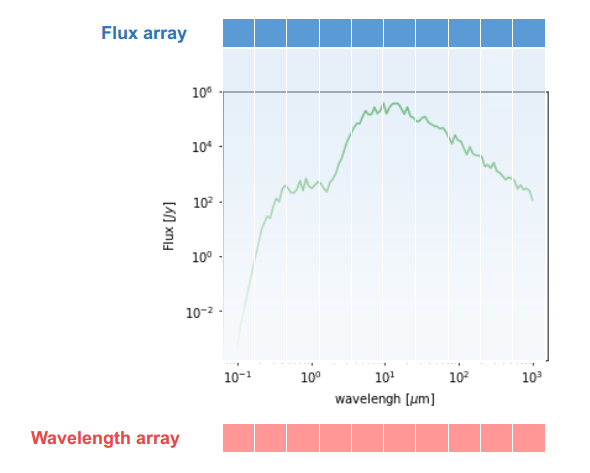

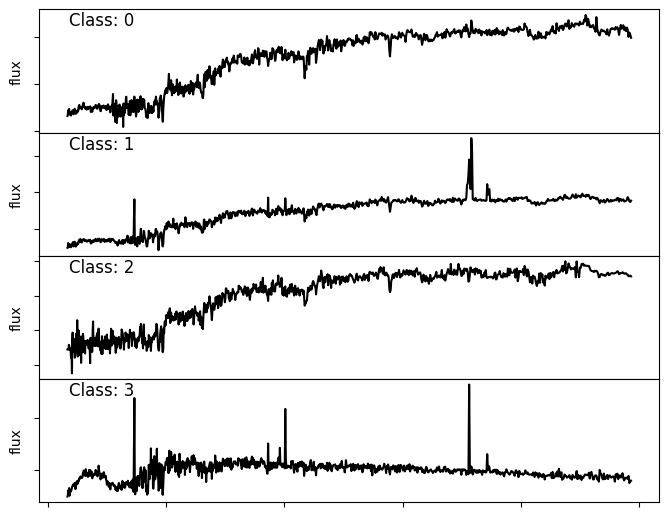

Class demographics:
'-- Class: 0 | count: 316
'-- Class: 1 | count: 165
'-- Class: 2 | count: 236
'-- Class: 3 | count: 283


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.datasets import sdss_corrected_spectra
# Fetch the data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()

X = sdss_corrected_spectra.reconstruct_spectra(data)
y = np.load('data/spectra_classes.npy')

# Removing classes with too few counts:
labels, counts = np.unique(y, return_counts=True)
mask = np.isin(y, [labels[i] for i in range(len(labels)) if counts[i] > 50])
X = X[mask]
y = y[mask]

# Restricting dataset to speed up calculations:
X = X[:1000]
y = y[:1000]

# Ploting a few spectra ------------------------------------------------------
lam = sdss_corrected_spectra.compute_wavelengths(data)

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0)

for i, class_ in enumerate(np.unique(y)):
    idx_class_i = list(np.where(y == class_)[0])[0]
    # first index at which class <i> appears
    
    ax = fig.add_subplot(511 + i)
    ax.set_title('Class: %s' % y[idx_class_i], x=0.1, y=0.8)
    ax.plot(lam, X[idx_class_i], '-k')

    if i < 4:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_xlabel(r'wavelength $(\AA)$')

    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_ylabel('flux')

plt.show()
#-----------------------------------------------------------------------------

labels_, counts_ = np.unique(y, return_counts=True)
print('Class demographics:')
for label_, count_ in zip(labels_, counts_):
    print("'-- Class: %s | count: %s" % (label_, count_))

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Task**: You will have to:

1. Keep a hold-out test set aside.
2. Create a pipeline which includes some preprocessing, plus a classifier.<br>
&emsp; _You can pick any classifier/pre-processing combination you like, and any hyperparameter grid you like._
3. Use a [`RandomSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) to tune the pipeline hyperparameters.  
4. Assess your results on the hold-out test set.

<u>Hint</u>:<br>
- Start by making a functional pipeline (_nobody will judge if you copy code from above!_) 
- Later, you can try e.g. a [`QuantileTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html) followed by a [`SVM`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)<br>
- [**extra**] add in also a [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) decomposition, whose hyperparameter is the number of _embedded_ dimensions (_= Principal Components to keep_)

<u>References</u>:
- Here is a list of [`sklearn` classifiers](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
- Here is a list of [`sklearn` scalers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)
- Here is a pipeline [example including `PCA`](https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html) (_although applied to Regression_)

Remember $-$ to discover all the parameters of an algorithm, you can:
- check its `sklearn` documentation, or
- import the algorithm and type: `<AlgorithmName>?`    
    
<u>Note</u>: For the purpose of this exercise, you don't need to deeply _understand_ all the hyperparameters of what you are using.  Just throw them into the the search (hopefully with a sensible range).
    
</div>    

In [ ]:
%%time

############################################
# Replace "..." with the appropriate code! #
############################################

# 1- Keeping a hold-out test set aside:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=..., random_state=42)

# 2- Creating a pipeline and parameter grid:
from sklearn ... # import your classifier
from sklearn ... # import your preproccessing step(s)
from sklearn.pipeline import Pipeline

# Customize your pipeline:
model = Pipeline([
    ...,
    ...,
    ...
])
'''
NOTE: This should follow the format we saw above, e.g.:

          model = Pipeline([
            ('scaler', QuantileTransformer()),
            ('RFC', RandomForestClassifier())
          ])
''';

display(model)

from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_grid = {
    ...,
    ...,
    ...
}
"""
NOTE: This should follow the format we saw above, e.g.:

          param_grid = {
              "PCA__random_state": [42],
              "PCA__n_components": [2, 3, 5],
              "RFC__n_estimators": [10, 20, 50, 100],
              "RFC__max_depth": np.arange(2, 10, 2),
          }
""";

display(param_grid)

# 3- Performing the search:
search = RandomizedSearchCV(model, param_grid, cv=..., n_iter=...,
                            scoring='accuracy', refit=True, random_state=42,
                            n_jobs=1, verbose=3)
search.fit(X_train, y_train)

print('\nBest configuration [selected by score = %.2f]:' % search.best_score_)
display(search.best_estimator_)

# 4- Assessing the results:
from sklearn.metrics import accuracy_score

yhat_test = search.best_estimator_.predict(X_test)

# Evaluating score:
score = accuracy_score(..., ...)

print('\nAccuracy of best configuration on held-out test set: %.2f' % score)

# Level 4 $-$ Model selection

> _What if I want to select among different models?_

<table><tr>
    <td width=800>
        <img src=attachment:Goku_SS3.png>
    </td>
</tr></table>

In the most **general** way, what if we want to try:
- _different pre-processing algorithms?_
- _different estimators?_

... <u>and</u> $-$ for all of these $-$ experiment with different hyperparameters?
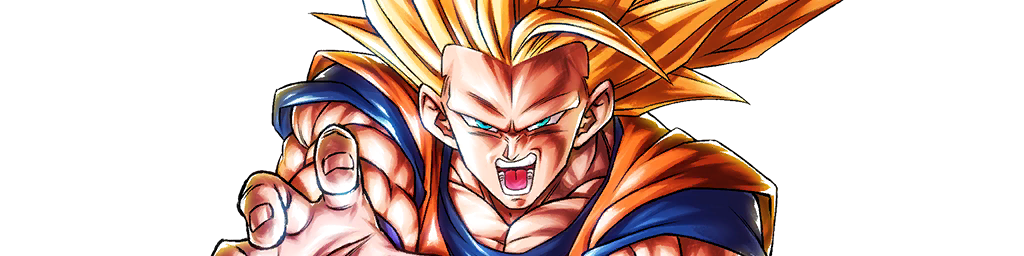

<font size=3><u>**How can this search be designed?**</u><font>

We need to think the model configuration as a huge **hyperparameter array**:

<table><tr>
    <td width=640>
        <img src=attachment:Model_Hyperparameters.jpg>
        <center>
            <br>
            Figure 3.1.  Hyperparameters for the generic model template shown above.
            Individual steps might be switched on/off by creating a proxy
            hyperparameter
            that can take a value of 1 if the specific step is used, or 0 if not.
            <br>
        </center>
    </td>
</tr></table>
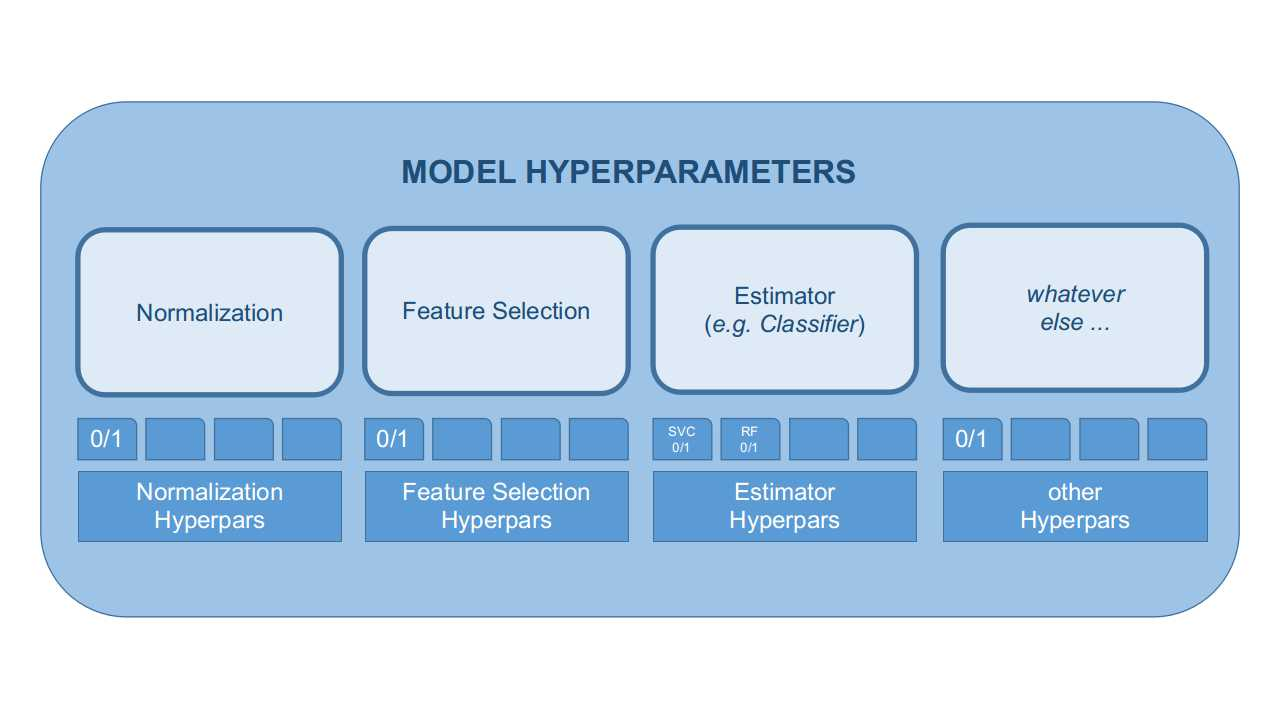

In this paradigm, we can _imagine_ switching between algorithms by turning **on or off** special hyperparameter entries.

_See Figure:_<br>
&emsp; _We can pick Random Forests over Support Vector Classifier by setting RF = 1 and SVC = 0._<br>
&emsp; _Consequently, all the SVC-related hyperparameters will be ignored._

$\rightarrow$ Our **hyperparameter search** can then be performed **as usual** (<b>Cross-Validation with Tuning</b>, a.k.a. <b>CVT</b>):

<table><tr>
    <td width=800>
        <img src=attachment:CV_k4_model_selection.png>
        <center>
            <br>
            Figure 3.2. The most generic version of Cross Validation protocol for model selection and assesment.
        </center>
    </td>
</tr></table>
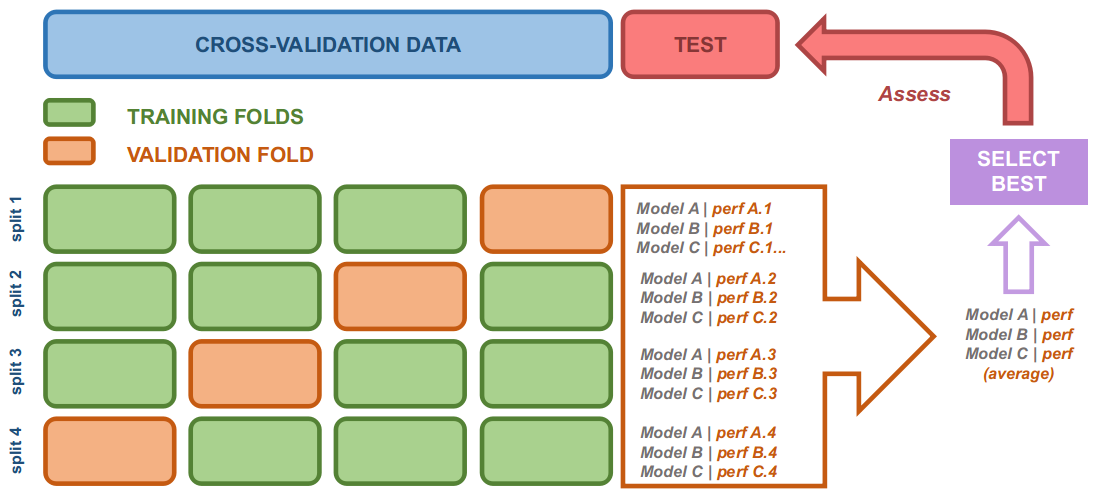

<font size=3><u>**Important**</u><font>

At the end of the procedure, we may state:<br>
    
> _We can fit the input data with \<this much\> performance_

But, is this performance attributed to _that_ configuration alone? $\rightarrow$ **NO**
    
_WHY?_
    
- The selected configuration may be _any_ of the ones in the model pool
- If we randomize the data a bit and repeat, we may select a _different_ model
    
$\rightarrow$ In practice, the actual configuration of the _selected_ model is not so relevant.   
   
We need to think CVT as a:

> **learning method**: the procedure of finding the best-fitting model    
    
$\rightarrow$ The performance is that of the model search <u>as a whole</u>.


<font size=3><u>**I am going to fall asleep, just tell me how it is done in Python already**</u><font>

- Bad news $-$ `sklearn` does <u>not</u> support "_hybrid_" pipelines.
    
- Good news $-$ the AstroStatistics School has your back.

In [13]:
# The magic trick is to use this package -------------------------------------
# PipelineHelper: https://github.com/bmurauer/pipelinehelper
from pipelinehelper import PipelineHelper
#-----------------------------------------------------------------------------

# CV tools:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
# Scalers:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
# Classifiers:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
# Metrics:
from sklearn.metrics import accuracy_score

In [14]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=42)

'''Define here all possible models that you want to attempt:

    In particular, this pipeline trains, for each CV iteration, one
    combination of:
   - a scaler (sampled between StandardScaler or MaxAbsScaler)
   - a classifier (sampled between LinearSVC or RandomForestClassifier)
'''
models = Pipeline([
    ('scaler', PipelineHelper([
        ('std', StandardScaler()),
        ('max', MaxAbsScaler()),
    ])),
    ('classifier', PipelineHelper([
        ('svm', svm.SVC()),
        ('rf', RandomForestClassifier()),
    ])),
])

'''Define here the parameter you want to sample, for each scaler
and each classifier:

    In particular, this pipeline tries:
    - using mean and/or standard deviation to scale the data
    - different C parameters for the Support Vector machine Classifier 
    - different n_estimators for the Random Forests

    NOTE1: MaxAbsScaler takes no parameters!
    NOTE2: You can just throw in all the parameters; the PipelineHelper
           will take care to attribute them to the correct algorithm
'''

param_grid = {
    'scaler__selected_model': models.named_steps['scaler'].generate({
        'std__with_mean': [True, False],
        'std__with_std': [True, False],
    }),
    'classifier__selected_model': models.named_steps['classifier'].generate({
        'svm__C': [0.1, 1.0],
        'rf__n_estimators': [20, 100],
    })
}

# The rest follows exactly as seen earlier ...

search = RandomizedSearchCV(models, param_grid, cv=5, n_iter=20,
                            scoring='accuracy', refit=True, random_state=42,
                            n_jobs=1, verbose=3)

search.fit(X_train, y_train)

print('\nBest configuration [selected by score = %.2f]:' % search.best_score_)
display(search.best_estimator_)

yhat_test = search.best_estimator_.predict(X_test)
score = accuracy_score(y_test, yhat_test)

print('\nAccuracy of best configuration on held-out test set: %.2f' % score)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END classifier__selected_model=('svm', {'C': 0.1}), scaler__selected_model=('std', {'with_mean': True, 'with_std': True});, score=0.614 total time=   0.1s
[CV 2/5] END classifier__selected_model=('svm', {'C': 0.1}), scaler__selected_model=('std', {'with_mean': True, 'with_std': True});, score=0.600 total time=   0.1s
[CV 3/5] END classifier__selected_model=('svm', {'C': 0.1}), scaler__selected_model=('std', {'with_mean': True, 'with_std': True});, score=0.629 total time=   0.1s
[CV 4/5] END classifier__selected_model=('svm', {'C': 0.1}), scaler__selected_model=('std', {'with_mean': True, 'with_std': True});, score=0.600 total time=   0.1s
[CV 5/5] END classifier__selected_model=('svm', {'C': 0.1}), scaler__selected_model=('std', {'with_mean': True, 'with_std': True});, score=0.636 total time=   0.1s
[CV 1/5] END classifier__selected_model=('svm', {'C': 0.1}), scaler__selected_model=('std', {'with_mean': True, 'with_

[CV 4/5] END classifier__selected_model=('rf', {'n_estimators': 20}), scaler__selected_model=('std', {'with_mean': True, 'with_std': True});, score=0.879 total time=   0.1s
[CV 5/5] END classifier__selected_model=('rf', {'n_estimators': 20}), scaler__selected_model=('std', {'with_mean': True, 'with_std': True});, score=0.929 total time=   0.1s
[CV 1/5] END classifier__selected_model=('rf', {'n_estimators': 20}), scaler__selected_model=('std', {'with_mean': True, 'with_std': False});, score=0.907 total time=   0.1s
[CV 2/5] END classifier__selected_model=('rf', {'n_estimators': 20}), scaler__selected_model=('std', {'with_mean': True, 'with_std': False});, score=0.929 total time=   0.1s
[CV 3/5] END classifier__selected_model=('rf', {'n_estimators': 20}), scaler__selected_model=('std', {'with_mean': True, 'with_std': False});, score=0.943 total time=   0.1s
[CV 4/5] END classifier__selected_model=('rf', {'n_estimators': 20}), scaler__selected_model=('std', {'with_mean': True, 'with_std':

Pipeline(steps=[('scaler',
                 PipelineHelper(available_models={'max': MaxAbsScaler(),
                                                  'std': StandardScaler()},
                                selected_model=StandardScaler())),
                ('classifier',
                 PipelineHelper(available_models={'rf': RandomForestClassifier(),
                                                  'svm': SVC()},
                                selected_model=RandomForestClassifier()))])


Accuracy of best configuration on held-out test set: 0.91


<div class="alert alert-block alert-warning" style="margin-top: 20px">

##  In-class Exercise: Create and perform a model search [20 mins]

**Objective**: Find the best model for a classification task on galaxy spectra.

**Dataset**: We will use the SDSS spectra [dataset](https://epyc.astro.washington.edu/~bsipocz/astroml/regression/_build/html/examples/datasets/plot_corrected_spectra.html) $-$ but for you it will just be `X` and `y`, the content doesn't matter now.

**Task**: You will have to create a hybrid pipeline _and_ search space of your choice to maximize the score.

As classifiers, you will have to utilize two **Super Star Destroyers** of the estimators' family:
- [`XGBoost`](https://xgboost.readthedocs.io/en/stable/)
- [`LightGBM`](https://lightgbm.readthedocs.io/en/latest/index.html)

<u>WARNING:</u> Keep the `n_estimators` hyperparameter below 200 or so, or the fit will take too long.
    
</div>    

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.datasets import sdss_corrected_spectra
# Fetch the data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()

X = sdss_corrected_spectra.reconstruct_spectra(data)
y = np.load('data/spectra_classes.npy')

# Removing classes with too few counts:
labels, counts = np.unique(y, return_counts=True)
mask = np.isin(y, [labels[i] for i in range(len(labels)) if counts[i] > 50])
X = X[mask]
y = y[mask]

# Restricting dataset to speed up calculations:
X = X[:1000]
y = y[:1000]

labels_, counts_ = np.unique(y, return_counts=True)
print('Class demographics:')
for label_, count_ in zip(labels_, counts_):
    print("'-- Class: %s | count: %s" % (label_, count_))  

Class demographics:
'-- Class: 0 | count: 316
'-- Class: 1 | count: 165
'-- Class: 2 | count: 236
'-- Class: 3 | count: 283


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=42)  

<div class="alert alert-block alert-warning" style="margin-top: 20px">

Let's display here all the possible tunable hyperparameters of `XGBClassifier` and `LGBMClassifier`:
    
</div>    

In [17]:
from xgboost import XGBClassifier
print('Tunable hyperpars:', XGBClassifier().get_params())
'''
NOTE: In the documentation:
        'learning_rate' == 'eta'
''';
# See hints on XGBRegressor ranges here:
#     https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Tunable hyperpars: {'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [18]:
from lightgbm import LGBMClassifier
print('Tunable hyperpars:', LGBMClassifier().get_params())
'''
NOTE: In the documentation:
        'n_estimators' == 'n_iterations'
        'subsample' == 'bagging_fraction'
        'colsample_bytree' == 'feature_fraction'
        'reg_alpha' == 'lambda_l1'
''';
# WARNING: Don't use 'rf' as `boosting_type`, it will raise an error
#          (it expects a `bagging_frac` hyperpar instead of `subsample`).

Tunable hyperpars: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


<div class="alert alert-block alert-warning" style="margin-top: 20px">

Now you are ready to go $-$ just pick a few hyperparameters to tune, for each classifier.
    
<u>Note</u>: Don't overthink on this choice: treat the hyperparameters as "black boxes", and set the search ranges around their default values.

</div>

In [ ]:
%%time

############################################
# Replace "..." with the appropriate code! #
############################################

# CV tools:
from pipelinehelper import PipelineHelper
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
# Scalers:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
# Dimensionality reduction:
from sklearn.decomposition import PCA
# Metrics:
from sklearn.metrics import accuracy_score

models = Pipeline([
    ('scaler', PipelineHelper([
        ('std', StandardScaler()),
        ('max', MaxAbsScaler()),
    ])),
    ('embedder', PipelineHelper([
        ('PCA', PCA()),
    ])),
    ... # classifier algorithms
    ... # classifier algorithms   
    ... # classifier algorithms   
])

param_grid = {
    'embedder__selected_model': models.named_steps['embedder'].generate({
        'PCA__random_state': [42],
        'PCA__n_components': [2, 3, 5],
    }),
    'scaler__selected_model': models.named_steps['scaler'].generate({
        'std__with_mean': [True, False],
        'std__with_std': [True, False],
    }),
    ... # classifier hyperpars
    ... # classifier hyperpars
    ... # classifier hyperpars
}

search = RandomizedSearchCV(models, param_grid, cv=5, n_iter=20,
                            scoring='accuracy', refit=True, random_state=42,
                            n_jobs=1, verbose=3)

search.fit(X_train, y_train)

print('\nBest configuration [selected by score = %.2f]:' % search.best_score_)
display(search.best_estimator_)

yhat_test = search.best_estimator_.predict(X_test)
score = accuracy_score(y_test, yhat_test)

print('\nAccuracy of best configuration on held-out test set: %.2f' % score)

# Level 5 $-$ Efficient model selection

> _Can we make our learning method more efficient?_

<table><tr>
    <td width=800>
        <img src=attachment:Goku_SS4.png
    </td>
</tr></table>

The possible variants one can try when exploring models are potentially _very large_.<br>
We cannot afford to spend infinite time fitting!

Solutions include:
 - consider _previous knowledge_ of models performance in the learning method (**meta features**)
 - **early dropping** of poorly performing models (_not to fit them at every iteration_)
 - address the whole issue as an **optimization problem** (_see_ `Optimization.ipynb` _notebook_)

See also: **AutoML** $\rightarrow$ [2022 Summer School for Astrostatistics in Crete - ML Practices W
](https://github.com/astrostatistics-in-crete/2022_summer_school/blob/main/ML_Practices/ML_Practices_W.ipynb)

 
## Bayesian Optimization $-$ teaser

 > _A safe all-round bet might be the successful **Bayesian Optimization**_

Bayesian Optimization is an iterative search strategy that strikes a <u>balance between</u>:
- exploring promising areas **near the current optimal**
- exploring promising areas in **unexplored regions** of the parameter space
 
We won't delve into the theory ([check this blog](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f) for a good introduction)  $\rightarrow$ Let's just see how easily it can be used in Python.

Some Python libraries are:
- [`Hyperopt`](http://hyperopt.github.io/hyperopt/)
- [`Optuna`](https://optuna.org/)
- [`GPyOpt`](https://sheffieldml.github.io/GPyOpt/)
- [`Mango`](https://github.com/ARM-software/mango)

In Bayesian Optimization, we must frame the problem as **Objective Function** $\rightarrow$ _e.g., the Objective is the accuracy found by XGBoost_
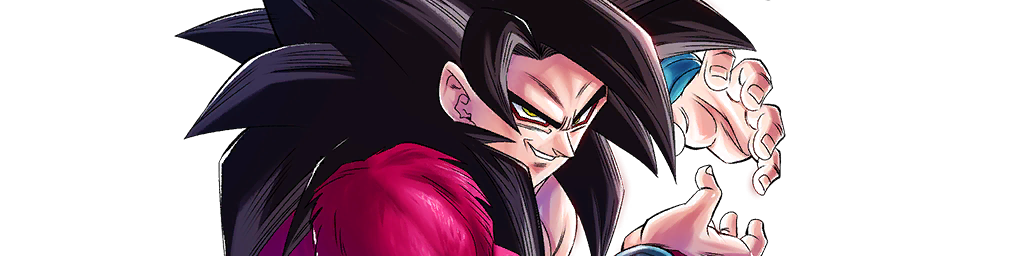

In [20]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import optuna

class Objective:
    def __init__(self, X_, y_):
        '''This contains some pre-processing.'''
        
        # Internally splitting into "train" and "validation" folds, similarly to CV:
        self.X_train, self.X_valid, self.y_train, self.y_valid = \
            train_test_split(X_, y_, test_size=0.3, random_state=42)
 
    def __call__(self, trial):
        '''This contains essentially what would happen inside a single
        iteration of `RandomizedSearchCV` or `GridSearchCV`.'''

        # Getting a "suggested" configuration for the current iteration:
        params_trial = {
            'eta':          trial.suggest_categorical('eta', [0.01, 0.1, 0.2, 0.5, 0.8, 0.99]),
            'max_depth':    trial.suggest_categorical('max_depth', [None, 3, 5, 7, 10, 20]),
            'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300]),
            'reg_alpha':    trial.suggest_categorical('reg_alpha', [0.001, 0.01, 0.1, 1, 5, 10]),
            'reg_lambda':   trial.suggest_categorical('reg_lambda', [0.01, 0.1, 1, 10, 20]),
            'subsample':    trial.suggest_categorical('subsample', [0.3, 0.5, 0.8, 0.9]),
        }
        
        # Training and evaluating the model:
        model = XGBClassifier(**params_trial, booster='gbtree', random_state=42)

        model.fit(self.X_train, self.y_train, verbose=False)

        yhat_valid = model.predict(self.X_valid)

        score = accuracy_score(self.y_valid, yhat_valid)

        return score

In [21]:
%%time

study = optuna.create_study(direction='maximize') 
# we want to maximize the score, which in our case is the accuracy
study.optimize(Objective(X_train, y_train), n_trials=10, show_progress_bar=True)
# let's try at most `n_trials` trials, after all we are trying to search smarter, not harder!

print('Number of completed trials:', len(study.trials))
print('Best trial:')
display(study.best_trial.params)

# To visualize hyperparameter importance in the optimization procedure:
# (requires proper installation of plotly)
#fig = optuna.visualization.plot_param_importances(study)
#fig.show()

[I 2024-05-07 21:58:57,926] A new study created in memory with name: no-name-86bd9606-ffe5-4ff1-a09b-cbbbc37becaa
/data/software/miniconda3/envs/astrostat23/lib/python3.9/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-05-07 21:59:01,195] Trial 0 finished with value: 0.9 and parameters: {'eta': 0.99, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 0.01, 'reg_lambda': 10, 'subsample': 0.8}. Best is trial 0 with value: 0.9.
[I 2024-05-07 21:59:04,426] Trial 1 finished with value: 0.9428571428571428 and parameters: {'eta': 0.99, 'max_depth': None, 'n_estimators': 200, 'reg_alpha': 0.01, 'reg_lambda': 20, 'subsample': 0.9}. Best is trial 1 with value: 0.9428571428571428.
[I 2024-05-07 21:59:05,885] Trial 2 finished with value: 0.8095238095238095 and parameters: {'eta': 0.99, 'max_depth': 10, 'n_estimators': 100, 'reg_alpha': 10, 'reg_lambda': 1, 'subsample': 0.8}. Best is trial 1 with value: 0.9428571428571428.
[I 2024-05-07 21:59:09,226] Trial 3 finished with value: 0.919047619047619 and parameters: {'eta': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 10, 'subsample': 0.3}. Best is trial 1 with value: 0.9428571428571428.
[I 2024-05-07 21:59:14,057] Trial 4 finished w

{'eta': 0.99,
 'max_depth': None,
 'n_estimators': 200,
 'reg_alpha': 0.01,
 'reg_lambda': 20,
 'subsample': 0.9}

CPU times: user 4min 21s, sys: 370 ms, total: 4min 21s
Wall time: 33.3 s


In [ ]:
###EOF